In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# Load muc123a
part123a = pd.read_csv('/content/muc123a.csv')
part123a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38253 entries, 0 to 38252
Data columns (total 56 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tinh      38253 non-null  int64  
 1   huyen     38253 non-null  int64  
 2   xa        38253 non-null  float64
 3   diaban    38253 non-null  int64  
 4   hoso      38253 non-null  int64  
 5   matv      38253 non-null  int64  
 6   m1ac2     38253 non-null  int64  
 7   m1ac3     38253 non-null  int64  
 8   m1ac4a    38253 non-null  int64  
 9   m1ac4b    38253 non-null  int64  
 10  m1ac5     38253 non-null  int64  
 11  m1ac6     30909 non-null  float64
 12  m1ac7     38253 non-null  int64  
 13  m1ac7a    1186 non-null   float64
 14  m1ac8     38253 non-null  int64  
 15  m1ac9     163 non-null    float64
 16  m1ac10a   179 non-null    float64
 17  m1ac10b   176 non-null    float64
 18  m2ac1     38253 non-null  int64  
 19  m2ac2     12303 non-null  float64
 20  m2ac3a    25950 non-null  fl

In [ ]:
# Create household size column
part123a['hsize'] = part123a.groupby(['tinh','huyen','xa','diaban','hoso'])['matv'].transform('max')

# Filter to keep only rows where m1ac3 == 1 (household head)
part123a.drop(part123a[(part123a['m1ac3'] != 1) | (part123a['m1ac2'] != 1)].index, inplace=True)

# Keep only household heads who are male and age ≥ 25
part123a = part123a[(part123a['m1ac3'] == 1) & (part123a['m1ac2'] == 1) & (part123a['m1ac5'] >= 25)]

# We take m123a as the base to merge the labels of other files
# Only keep the variables of label and individuals age
col123a = ['tinh', 'huyen', 'xa', 'diaban', 'hoso','matv','hsize', 'm1ac2', 'm1ac3', 'm1ac5']

# Keep only the selected columns in the dataset
part123a = part123a[col123a]

# Select the columns from muc123a to create a new dataframe
df = part123a[col123a].copy()

In [ ]:
# Import income file
part4a = pd.read_csv('/content/muc4a.csv')

# Define the required columns (household identifiers + selected variables)
# m4ac7: average days work per month, m4ac8: average hours work per day
# m4ac11: cash received from main job, m4ac12f: other salary
# m4ac21: cash received from secondary job, m4ac22f: other salary 1, m4ac25: other salary 2
# m4ac27: average hours per day for secondary job
col4a = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'matv', 'm4ac6', 'm4ac7', 'm4ac8',
           'm4ac16', 'm4ac17', 'm4ac18', 'm4ac11', 'm4ac12f', 'm4ac21', 'm4ac22f', 'm4ac25']

# Filter the dataset to keep only the selected columns
part4a = part4a[col4a]

# Create a new column that sums the selected variables for individual's income
part4a['indi_income'] = part4a[['m4ac11', 'm4ac12f','m4ac21', 'm4ac22f', 'm4ac25']].sum(axis=1)

# Group by household ID to calculate total household income
hh_income = part4a.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])['indi_income'].sum().reset_index()

# Rename column for clarity
hh_income.rename(columns={'indi_income': 'HH_Income'}, inplace=True)

# Merge household income back into the individual-level dataset
part4a = part4a.merge(hh_income, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Fill NaN values with zero
part4a.fillna(0, inplace=True)

# Create a new dataframe to merge all files
df = df.merge(part4a, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'matv'], how='left')

In [ ]:
df

,tinh,huyen,xa,diaban,hoso,matv,hsize,m1ac2,m1ac3,m1ac5,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,1,3,1,1,64,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,1,2,1,1,61,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,1,2,1,1,50,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,1,3,1,1,50,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,1,4,1,1,35,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,1,6,1,1,78,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,1,4,1,1,32,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,1,3,1,1,57,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,1,5,1,1,45,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load household expenditure of food and drinks during holidays (5A1)
part5a1 = pd.read_csv('/content/muc5a1.csv')

# Define the required columns (household identifiers + selected variables)
# m5a1c2b: expense bought, m5a1c3b: expense self supplied or received
col5a1 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm5a1c2b', 'm5a1c3b']

# Filter the dataset to keep only the selected columns
part5a1 = part5a1[col5a1]

# Group by household ID and sum the expenses
exp1 = part5a1.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])[['m5a1c2b', 'm5a1c3b']].sum().reset_index()

# Create a new column for total expense
exp1['HH_exp1'] = exp1['m5a1c2b'] + exp1['m5a1c3b']

# Merge back to the original dataset
part5a1 = part5a1.merge(exp1, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Drop duplicates so that each 'hoso' appears only once
part5a1 = part5a1.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first')

part5a1

,tinh,huyen,xa,diaban,hoso,m5a1c2b_x,m5a1c3b_x,m5a1c2b_y,m5a1c3b_y,HH_exp1
0,101,1,3.0,1,13,336.0,0.0,1288.3,296.1,1584.4
17,101,1,3.0,1,14,153.6,NaN,3473.3,1146.0,4619.3
40,101,1,3.0,1,15,86.4,NaN,2957.7,573.0,3530.7
63,101,1,9.0,19,15,28.8,0.0,1555.2,0.0,1555.2
80,101,1,9.0,19,19,76.8,NaN,1852.8,0.0,1852.8
...,...,...,...,...,...,...,...,...,...,...
134602,823,13,12.0,25,15,4.8,NaN,278.4,38.2,316.6
134612,823,13,12.0,25,19,164.7,NaN,573.7,81.9,655.6
134625,823,13,17.0,1,13,19.2,NaN,242.5,286.5,529.0
134634,823,13,17.0,1,14,100.0,0.0,482.0,0.0,482.0


In [ ]:
# Create a new dataframe to merge all files
df = part5a1.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m5a1c2b_x,m5a1c3b_x,m5a1c2b_y,m5a1c3b_y,HH_exp1,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,153.6,NaN,3473.3,1146.0,4619.3,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,86.4,NaN,2957.7,573.0,3530.7,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,28.8,0.0,1555.2,0.0,1555.2,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,103.7,NaN,1993.9,0.0,1993.9,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,115.2,NaN,5259.8,0.0,5259.8,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,4.8,NaN,278.4,38.2,316.6,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,164.7,NaN,573.7,81.9,655.6,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,19.2,NaN,242.5,286.5,529.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,100.0,0.0,482.0,0.0,482.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load household daily expenditure on food and drinks
part5a2 = pd.read_csv('/content/muc5a2.csv')

# Define the required columns (household identifiers + selected variables)
# m5a2c6: expense bought, m5a2c10: expense self supplied or received
col5a2 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm5a2c6', 'm5a2c10']

# Filter the dataset to keep only the selected columns
part5a2 = part5a2[col5a2]

# Group by household ID and sum the expenses
exp2 = part5a2.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])[['m5a2c6', 'm5a2c10']].sum().reset_index()

# Create a new column for total expense
exp2['HH_exp2'] = exp2['m5a2c6'] + exp2['m5a2c10']

# Merge back to the original dataset
part5a2 = part5a2.merge(exp2, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Drop duplicates so that each 'hoso' appears only once
part5a2 = part5a2.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first')

part5a2

,tinh,huyen,xa,diaban,hoso,m5a2c6_x,m5a2c10_x,m5a2c6_y,m5a2c10_y,HH_exp2
0,101,1,3.0,1,13,345.6,NaN,24438.8,0.0,24438.8
43,101,1,3.0,1,14,36.5,NaN,36904.7,0.0,36904.7
95,101,1,3.0,1,15,208.8,NaN,38741.9,0.0,38741.9
150,101,1,9.0,19,15,715.2,NaN,17770.4,0.0,17770.4
178,101,1,9.0,19,19,96.0,NaN,20078.0,0.0,20078.0
...,...,...,...,...,...,...,...,...,...,...
310363,823,13,12.0,25,15,144.0,NaN,10468.8,2578.5,13047.3
310385,823,13,12.0,25,19,175.2,NaN,8964.7,1092.0,10056.7
310411,823,13,17.0,1,13,22.8,NaN,7349.5,1056.2,8405.7
310426,823,13,17.0,1,14,180.0,NaN,9983.0,3600.0,13583.0


In [ ]:
# Create a new dataframe to merge all files
df = part5a2.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m5a2c6_x,m5a2c10_x,m5a2c6_y,m5a2c10_y,HH_exp2,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,36.5,NaN,36904.7,0.0,36904.7,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,208.8,NaN,38741.9,0.0,38741.9,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,715.2,NaN,17770.4,0.0,17770.4,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,768.0,NaN,22501.7,0.0,22501.7,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,259.2,NaN,51339.0,0.0,51339.0,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,144.0,NaN,10468.8,2578.5,13047.3,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,175.2,NaN,8964.7,1092.0,10056.7,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,22.8,NaN,7349.5,1056.2,8405.7,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,180.0,NaN,9983.0,3600.0,13583.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load household daily expenditure on nonfood and others
part5b1 = pd.read_csv('/content/muc5b1.csv')

# Define the required columns (household identifiers + selected variables)
# m5b1c4: expense recieved, m5b1c5: annual expense
col5b1 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso','m5b1c4', 'm5b1c5']

# Filter the dataset to keep only the selected columns
part5b1 = part5b1[col5b1]

# Group by household ID and sum the expenses
exp3 = part5b1.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])[['m5b1c4','m5b1c5']].sum().reset_index()

# Create a new column for total expense
exp3['HH_exp3'] = exp3['m5b1c4'] + exp3['m5b1c5']

# Merge back to the original dataset
part5b1 = part5b1.merge(exp3, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Drop duplicates so that each 'hoso' appears only once
part5b1 = part5b1.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first')

part5b1

,tinh,huyen,xa,diaban,hoso,m5b1c4_x,m5b1c5_x,m5b1c4_y,m5b1c5_y,HH_exp3
0,101,1,3.0,1,13,14.0,0.0,7560.0,0.0,7560.0
15,101,1,3.0,1,14,360.0,0.0,21586.0,0.0,21586.0
34,101,1,3.0,1,15,300.0,0.0,21488.0,0.0,21488.0
52,101,1,9.0,19,15,120.0,0.0,7012.0,0.0,7012.0
66,101,1,9.0,19,19,105.0,0.0,8190.0,0.0,8190.0
...,...,...,...,...,...,...,...,...,...,...
117718,823,13,12.0,25,15,204.0,0.0,1516.0,300.0,1816.0
117729,823,13,12.0,25,19,480.0,NaN,2070.0,600.0,2670.0
117742,823,13,17.0,1,13,200.0,0.0,911.0,720.0,1631.0
117751,823,13,17.0,1,14,120.0,0.0,1056.0,1080.0,2136.0


In [ ]:
# Create a new dataframe to merge all files
df = part5b1.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m5b1c4_x,m5b1c5_x,m5b1c4_y,m5b1c5_y,HH_exp3,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,360.0,0.0,21586.0,0.0,21586.0,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,300.0,0.0,21488.0,0.0,21488.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,120.0,0.0,7012.0,0.0,7012.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,55.0,0.0,9280.0,0.0,9280.0,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,420.0,0.0,17447.0,0.0,17447.0,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,204.0,0.0,1516.0,300.0,1816.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,480.0,NaN,2070.0,600.0,2670.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,200.0,0.0,911.0,720.0,1631.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,120.0,0.0,1056.0,1080.0,2136.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load household annual consumption expenditure
part5b2 = pd.read_csv('/content/muc5b2.csv')

# Define the required columns (household identifiers + selected variables)
# m5b2c2: expense bought, m5b2c3: expense self supplied or received
col5b2 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm5b2c2', 'm5b2c3']

# Filter the dataset to keep only the selected columns
part5b2 = part5b2[col5b2]

# Group by household ID and sum the expenses
exp4 = part5b2.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])[['m5b2c2', 'm5b2c3']].sum().reset_index()
part5b2
# Create a new column for total expense
exp4['HH_exp4'] = exp4['m5b2c2'] + exp4['m5b2c3']

# Merge back to the original dataset
part5b2 = part5b2.merge(exp4, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Drop duplicates so that each 'hoso' appears only once
part5b2 = part5b2.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first')

part5b2

,tinh,huyen,xa,diaban,hoso,m5b2c2_x,m5b2c3_x,m5b2c2_y,m5b2c3_y,HH_exp4
0,101,1,3.0,1,13,90.0,0.0,7350.0,0.0,7350.0
16,101,1,3.0,1,14,400.0,0.0,18950.0,0.0,18950.0
41,101,1,3.0,1,15,300.0,0.0,16235.0,0.0,16235.0
64,101,1,9.0,19,15,300.0,0.0,7130.0,0.0,7130.0
78,101,1,9.0,19,19,50.0,0.0,8060.0,0.0,8060.0
...,...,...,...,...,...,...,...,...,...,...
117872,823,13,12.0,25,15,10.0,0.0,391.0,0.0,391.0
117881,823,13,12.0,25,19,20.0,0.0,970.0,0.0,970.0
117890,823,13,17.0,1,13,30.0,0.0,355.0,0.0,355.0
117893,823,13,17.0,1,14,100.0,0.0,760.0,0.0,760.0


In [ ]:
# Create a new dataframe to merge all files
df = part5b2.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m5b2c2_x,m5b2c3_x,m5b2c2_y,m5b2c3_y,HH_exp4,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,400.0,0.0,18950.0,0.0,18950.0,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,300.0,0.0,16235.0,0.0,16235.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,300.0,0.0,7130.0,0.0,7130.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,520.0,0.0,10040.0,0.0,10040.0,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,1140.0,0.0,17091.0,0.0,17091.0,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,10.0,0.0,391.0,0.0,391.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,20.0,0.0,970.0,0.0,970.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,30.0,0.0,355.0,0.0,355.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,100.0,0.0,760.0,0.0,760.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load other spending that is considered as household expenditure
part5b3 = pd.read_csv('/content/muc5b3.csv')

# Define the required columns (household identifiers + selected variables)
# m5b3c2: annual expense
col5b3 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm5b3c2']

# Filter the dataset to keep only the selected columns
part5b3 = part5b3[col5b3]

# Group by household ID and sum the expenses
exp5 = part5b3.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'])[['m5b3c2']].sum().reset_index()

# Create a new column for total expense
exp5['HH_exp5'] = exp5['m5b3c2']

# Merge back to the original dataset
part5b3 = part5b3.merge(exp5, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Drop duplicates so that each 'hoso' appears only once
part5b3 = part5b3.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first')

part5b3

,tinh,huyen,xa,diaban,hoso,m5b3c2_x,m5b3c2_y,HH_exp5
0,101,1,3.0,1,13,70.0,2570.0,2570.0
3,101,1,3.0,1,14,4000.0,8150.0,8150.0
8,101,1,3.0,1,15,5000.0,7850.0,7850.0
12,101,1,9.0,19,15,60.0,760.0,760.0
15,101,1,9.0,19,19,70.0,770.0,770.0
...,...,...,...,...,...,...,...,...
31636,823,13,12.0,25,15,NaN,0.0,0.0
31637,823,13,12.0,25,19,NaN,0.0,0.0
31638,823,13,17.0,1,13,70.0,70.0,70.0
31639,823,13,17.0,1,14,300.0,300.0,300.0


In [ ]:
# Create a new dataframe to merge all files
df = part5b3.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m5b3c2_x,m5b3c2_y,HH_exp5,m5b2c2_x,m5b2c3_x,...,m4ac16,m4ac17,m4ac18,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income
0,101,1,3.0,1,14,4000.0,8150.0,8150.0,400.0,0.0,...,0.0,0.0,0.0,39528.0,2823,0.0,0,0.0,42351.0,56468.0
1,101,1,3.0,1,15,5000.0,7850.0,7850.0,300.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,42351.0
2,101,1,9.0,19,15,60.0,760.0,760.0,300.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,101,1,9.0,19,20,70.0,640.0,640.0,520.0,0.0,...,0.0,0.0,0.0,33061.0,918,0.0,0,0.0,33979.0,47203.0
4,101,1,15.0,50,13,300.0,1800.0,1800.0,1140.0,0.0,...,0.0,0.0,0.0,79055.0,12800,0.0,0,0.0,91855.0,163382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,NaN,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,27677.0
6893,823,13,12.0,25,19,NaN,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6894,823,13,17.0,1,13,70.0,70.0,70.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
6895,823,13,17.0,1,14,300.0,300.0,300.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [ ]:
# Load household's accomodation expenditure
part7 = pd.read_csv('/content/muc7.csv')

# Define the required columns (household identifiers + selected variables)
# m7c15: land or house/flat leasing
# m7c32: annual water expense, m7c36: annual electricity expense , m7c39: annual garbage collection expense
col7 = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm7c15', 'm7c32', 'm7c36', 'm7c39']

# Filter the dataset to keep only the selected columns
part7 = part7[col7]

# Calculate total housing expense
part7['HH_exp6'] = part7['m7c32'] + part7['m7c36'] + part7['m7c39']

part7

,tinh,huyen,xa,diaban,hoso,m7c15,m7c32,m7c36,m7c39,HH_exp6
0,101,1,3.0,1,13,NaN,840.0,3720.0,108.0,4668.0
1,101,1,3.0,1,14,NaN,720.0,3000.0,108.0,3828.0
2,101,1,3.0,1,15,NaN,1000.0,5000.0,72.0,6072.0
3,101,1,9.0,19,15,NaN,180.0,1440.0,72.0,1692.0
4,101,1,9.0,19,19,NaN,180.0,1680.0,108.0,1968.0
...,...,...,...,...,...,...,...,...,...,...
9184,823,13,12.0,25,15,NaN,NaN,840.0,NaN,NaN
9185,823,13,12.0,25,19,NaN,NaN,600.0,NaN,NaN
9186,823,13,17.0,1,13,NaN,NaN,NaN,NaN,NaN
9187,823,13,17.0,1,14,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create a new dataframe to merge all files
df = part7.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6897 entries, 0 to 6896
Data columns (total 51 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tinh         6897 non-null   int64  
 1   huyen        6897 non-null   int64  
 2   xa           6897 non-null   float64
 3   diaban       6897 non-null   int64  
 4   hoso         6897 non-null   int64  
 5   m7c15        89 non-null     float64
 6   m7c32        1718 non-null   float64
 7   m7c36        6657 non-null   float64
 8   m7c39        1726 non-null   float64
 9   HH_exp6      969 non-null    float64
 10  m5b3c2_x     6853 non-null   float64
 11  m5b3c2_y     6897 non-null   float64
 12  HH_exp5      6897 non-null   float64
 13  m5b2c2_x     6896 non-null   float64
 14  m5b2c3_x     6896 non-null   float64
 15  m5b2c2_y     6897 non-null   float64
 16  m5b2c3_y     6897 non-null   float64
 17  HH_exp4      6897 non-null   float64
 18  m5b1c4_x     6489 non-null   float64
 19  m5b1c5

In [ ]:
# Import household fixed assets (6A)
part6a = pd.read_csv('/content/muc6a.csv')

# Define the required columns (household identifiers + selected variables)
# m6ac3: quantity of the assets, m6ac6: assets' value at current price, m6ac7: percentage of ownership
part6a['m6ac7'] = part6a['m6ac7'] / 100
col6a = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6ac3', 'm6ac6', 'm6ac7']

# Filter the dataset to keep only the selected columns
part6a = part6a[col6a].fillna(0)

# Calculate total household fixed assets wealth
part6a['HH_wealth1'] = part6a['m6ac3'] * part6a['m6ac6'] * part6a['m6ac7']

# Aggregate total wealth by household
hh_wealth1 = part6a.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'], as_index=False)['HH_wealth1'].sum()

# Import household durable goods (6B)
part6b = pd.read_csv('/content/muc6b.csv')

# Define the required columns (household identifiers + selected variables)
# m6bc3: quantity of the durable appliance, m6bc6: durable appliance value at current price
col6b = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6bc3', 'm6bc6']

# Filter the dataset to keep only the selected columns
part6b = part6b[col6b].fillna(0)

# Calculate total household durable appliance wealth
part6b['HH_wealth2'] = part6b['m6bc3'] * part6b['m6bc6']

# Aggregate total durable appliance wealth by household
hh_wealth2 = part6b.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'], as_index=False)['HH_wealth2'].sum()

# Merge wealth data into df
df = df.merge(hh_wealth1, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')
df = df.merge(hh_wealth2, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

# Fill missing values with 0 (in case some households have no assets or durable goods)
df[['HH_wealth1', 'HH_wealth2']] = df[['HH_wealth1', 'HH_wealth2']].fillna(0)

# Calculate total household wealth
df['HH_Wealth'] = df['HH_wealth1'] + df['HH_wealth2']

df


,tinh,huyen,xa,diaban,hoso,m7c15,m7c32,m7c36,m7c39,HH_exp6,...,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income,HH_wealth1,HH_wealth2,HH_Wealth
0,101,1,3.0,1,14,NaN,720.0,3000.0,108.0,3828.0,...,39528.0,2823,0.0,0,0.0,42351.0,56468.0,0.0,107450.0,107450.0
1,101,1,3.0,1,15,NaN,1000.0,5000.0,72.0,6072.0,...,0.0,0,0.0,0,0.0,0.0,42351.0,0.0,68300.0,68300.0
2,101,1,9.0,19,15,NaN,180.0,1440.0,72.0,1692.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,21800.0,21800.0
3,101,1,9.0,19,20,NaN,180.0,1440.0,120.0,1740.0,...,33061.0,918,0.0,0,0.0,33979.0,47203.0,0.0,29500.0,29500.0
4,101,1,15.0,50,13,NaN,840.0,3600.0,60.0,4500.0,...,79055.0,12800,0.0,0,0.0,91855.0,163382.0,0.0,55150.0,55150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,NaN,NaN,840.0,NaN,NaN,...,0.0,0,0.0,0,0.0,0.0,27677.0,0.0,450.0,450.0
6893,823,13,12.0,25,19,NaN,NaN,600.0,NaN,NaN,...,0.0,0,0.0,0,0.0,0.0,0.0,45000.0,11600.0,56600.0
6894,823,13,17.0,1,13,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1750.0,1750.0
6895,823,13,17.0,1,14,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1550.0,1550.0


In [ ]:
# Import household fixed assets (6A)
part6a = pd.read_csv('/content/muc6a.csv')

# Define the required columns (household identifiers + selected variables)
# m6ac3: quantity of the assets, m6ac6: assets' value at current price , m6ac7: percentage of ownership
part6a['m6ac7'] = part6a['m6ac7']/100
col6a = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6ac3', 'm6ac6', 'm6ac7']

# Filter the dataset to keep only the selected columns
part6a = part6a[col6a]
part6a.fillna(0, inplace=True)

# Calculate total household assets
part6a['HH_wealth1'] = part6a['m6ac3'] * part6a['m6ac6'] * part6a['m6ac7']

# Group by household to get total wealth per household
hh_wealth1 = part6a.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'], as_index=False)['HH_wealth1'].sum()

# Merge back to the original dataset
part6a = part6a.merge(hh_wealth1, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

part6a.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first', inplace=True)

part6a

,tinh,huyen,xa,diaban,hoso,m6ac3,m6ac6,m6ac7,HH_wealth1_x,HH_wealth1_y
0,101,1,3.0,1,13,0.0,0.0,0.0,0.0,0.0
1,101,1,3.0,1,14,0.0,0.0,0.0,0.0,0.0
2,101,1,3.0,1,15,0.0,0.0,0.0,0.0,0.0
3,101,1,9.0,19,15,0.0,0.0,0.0,0.0,0.0
4,101,1,9.0,19,19,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18143,823,13,12.0,25,15,0.0,0.0,0.0,0.0,0.0
18144,823,13,12.0,25,19,1.0,45000.0,1.0,45000.0,45000.0
18145,823,13,17.0,1,13,0.0,0.0,0.0,0.0,0.0
18146,823,13,17.0,1,14,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create a new dataframe to merge all files
df = part6a.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m6ac3,m6ac6,m6ac7,HH_wealth1_x,HH_wealth1_y,...,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income,HH_wealth1,HH_wealth2,HH_Wealth
0,101,1,3.0,1,14,0.0,0.0,0.0,0.0,0.0,...,39528.0,2823,0.0,0,0.0,42351.0,56468.0,0.0,107450.0,107450.0
1,101,1,3.0,1,15,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0,0.0,0.0,42351.0,0.0,68300.0,68300.0
2,101,1,9.0,19,15,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,21800.0,21800.0
3,101,1,9.0,19,20,0.0,0.0,0.0,0.0,0.0,...,33061.0,918,0.0,0,0.0,33979.0,47203.0,0.0,29500.0,29500.0
4,101,1,15.0,50,13,0.0,0.0,0.0,0.0,0.0,...,79055.0,12800,0.0,0,0.0,91855.0,163382.0,0.0,55150.0,55150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0,0.0,0.0,27677.0,0.0,450.0,450.0
6893,823,13,12.0,25,19,1.0,45000.0,1.0,45000.0,45000.0,...,0.0,0,0.0,0,0.0,0.0,0.0,45000.0,11600.0,56600.0
6894,823,13,17.0,1,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1750.0,1750.0
6895,823,13,17.0,1,14,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1550.0,1550.0


In [ ]:
# Import household durable goods (6B)
part6b = pd.read_csv('/content/muc6b.csv')

# Define the required columns (household identifiers + selected variables)
# m6bc3: quantity of the durable applicance, m6bc6: durable appliance value at current price
col6b = ['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6bc3', 'm6bc6']

# Filter the dataset to keep only the selected columns
part6b = part6b[col6b]
part6b.fillna(0, inplace=True)

# Calculate total durable goods value of household
part6b['HH_wealth2'] = part6b['m6bc3'] * part6b['m6bc6']

# Group by household to get total wealth per household
hh_wealth2 = part6b.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso'], as_index=False)['HH_wealth2'].sum()

# Merge back to the original dataset
part6b = part6b.merge(hh_wealth2, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='left')

part6b.drop_duplicates(subset=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], keep='first', inplace=True)

part6b

,tinh,huyen,xa,diaban,hoso,m6bc3,m6bc6,HH_wealth2_x,HH_wealth2_y
0,101,1,3.0,1,13,2.0,1700.0,3400.0,24450.0
14,101,1,3.0,1,14,1.0,2500.0,2500.0,107450.0
37,101,1,3.0,1,15,1.0,500.0,500.0,68300.0
53,101,1,9.0,19,15,1.0,1700.0,1700.0,21800.0
65,101,1,9.0,19,19,1.0,500.0,500.0,35200.0
...,...,...,...,...,...,...,...,...,...
102075,823,13,12.0,25,15,1.0,150.0,150.0,450.0
102078,823,13,12.0,25,19,2.0,400.0,800.0,11600.0
102083,823,13,17.0,1,13,1.0,150.0,150.0,1750.0
102086,823,13,17.0,1,14,1.0,200.0,200.0,1550.0


In [ ]:
# Create a new dataframe to merge all files
df = part6b.merge(df, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')
df

,tinh,huyen,xa,diaban,hoso,m6bc3,m6bc6,HH_wealth2_x,HH_wealth2_y,m6ac3,...,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income,HH_wealth1,HH_wealth2,HH_Wealth
0,101,1,3.0,1,14,1.0,2500.0,2500.0,107450.0,0.0,...,39528.0,2823,0.0,0,0.0,42351.0,56468.0,0.0,107450.0,107450.0
1,101,1,3.0,1,15,1.0,500.0,500.0,68300.0,0.0,...,0.0,0,0.0,0,0.0,0.0,42351.0,0.0,68300.0,68300.0
2,101,1,9.0,19,15,1.0,1700.0,1700.0,21800.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,21800.0,21800.0
3,101,1,9.0,19,20,1.0,1500.0,1500.0,29500.0,0.0,...,33061.0,918,0.0,0,0.0,33979.0,47203.0,0.0,29500.0,29500.0
4,101,1,15.0,50,13,1.0,2000.0,2000.0,55150.0,0.0,...,79055.0,12800,0.0,0,0.0,91855.0,163382.0,0.0,55150.0,55150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,1.0,150.0,150.0,450.0,0.0,...,0.0,0,0.0,0,0.0,0.0,27677.0,0.0,450.0,450.0
6893,823,13,12.0,25,19,2.0,400.0,800.0,11600.0,1.0,...,0.0,0,0.0,0,0.0,0.0,0.0,45000.0,11600.0,56600.0
6894,823,13,17.0,1,13,1.0,150.0,150.0,1750.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1750.0,1750.0
6895,823,13,17.0,1,14,1.0,200.0,200.0,1550.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1550.0,1550.0


In [ ]:
df['HH_Wealth'] = df['HH_wealth1'] + df['HH_wealth2']
df

,tinh,huyen,xa,diaban,hoso,m6bc3,m6bc6,HH_wealth2_x,HH_wealth2_y,m6ac3,...,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income,HH_wealth1,HH_wealth2,HH_Wealth
0,101,1,3.0,1,14,1.0,2500.0,2500.0,107450.0,0.0,...,39528.0,2823,0.0,0,0.0,42351.0,56468.0,0.0,107450.0,107450.0
1,101,1,3.0,1,15,1.0,500.0,500.0,68300.0,0.0,...,0.0,0,0.0,0,0.0,0.0,42351.0,0.0,68300.0,68300.0
2,101,1,9.0,19,15,1.0,1700.0,1700.0,21800.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,21800.0,21800.0
3,101,1,9.0,19,20,1.0,1500.0,1500.0,29500.0,0.0,...,33061.0,918,0.0,0,0.0,33979.0,47203.0,0.0,29500.0,29500.0
4,101,1,15.0,50,13,1.0,2000.0,2000.0,55150.0,0.0,...,79055.0,12800,0.0,0,0.0,91855.0,163382.0,0.0,55150.0,55150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,1.0,150.0,150.0,450.0,0.0,...,0.0,0,0.0,0,0.0,0.0,27677.0,0.0,450.0,450.0
6893,823,13,12.0,25,19,2.0,400.0,800.0,11600.0,1.0,...,0.0,0,0.0,0,0.0,0.0,0.0,45000.0,11600.0,56600.0
6894,823,13,17.0,1,13,1.0,150.0,150.0,1750.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1750.0,1750.0
6895,823,13,17.0,1,14,1.0,200.0,200.0,1550.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1550.0,1550.0


In [ ]:
# m4ac6: working months annually (first),  m4ac7: average days work per month (first), m4ac8: average hours work per day (first)
# m4ac16: working months annually (secondary),  m4ac17: average days work per month (secondary), m4ac18: average hours work per day (secondary)
# m4ac11: cash received from main job, m4ac12f: other salary
# m4ac21: cash received from secondary job, m4ac22f: other salary 1, m4ac25: other salary 2

In [ ]:
df.to_csv('output.csv',index=False, encoding = 'utf-8-sig')

In [ ]:
df.to_csv('output2.csv',index=False, encoding = 'utf-8-sig')

In [ ]:
df

,tinh,huyen,xa,diaban,hoso,m6bc3,m6bc6,HH_wealth2_x,HH_wealth2_y,m6ac3,...,m4ac11,m4ac12f,m4ac21,m4ac22f,m4ac25,indi_income,HH_Income,HH_wealth1,HH_wealth2,HH_Wealth
0,101,1,3.0,1,14,1.0,2500.0,2500.0,107450.0,0.0,...,39528.0,2823,0.0,0,0.0,42351.0,56468.0,0.0,107450.0,107450.0
1,101,1,3.0,1,15,1.0,500.0,500.0,68300.0,0.0,...,0.0,0,0.0,0,0.0,0.0,42351.0,0.0,68300.0,68300.0
2,101,1,9.0,19,15,1.0,1700.0,1700.0,21800.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,21800.0,21800.0
3,101,1,9.0,19,20,1.0,1500.0,1500.0,29500.0,0.0,...,33061.0,918,0.0,0,0.0,33979.0,47203.0,0.0,29500.0,29500.0
4,101,1,15.0,50,13,1.0,2000.0,2000.0,55150.0,0.0,...,79055.0,12800,0.0,0,0.0,91855.0,163382.0,0.0,55150.0,55150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6892,823,13,12.0,25,15,1.0,150.0,150.0,450.0,0.0,...,0.0,0,0.0,0,0.0,0.0,27677.0,0.0,450.0,450.0
6893,823,13,12.0,25,19,2.0,400.0,800.0,11600.0,1.0,...,0.0,0,0.0,0,0.0,0.0,0.0,45000.0,11600.0,56600.0
6894,823,13,17.0,1,13,1.0,150.0,150.0,1750.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1750.0,1750.0
6895,823,13,17.0,1,14,1.0,200.0,200.0,1550.0,0.0,...,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1550.0,1550.0


In [ ]:
# Rename columns for clarity
df = df.rename(columns={"m1ac5": "age"})
# Compute log income
df["log_income"] = np.log(df["HH_Income"].replace(0, np.nan))

# Group by age and compute average log income
log_income_by_age = df.groupby("age")["log_income"].mean().reset_index()

# Exponentiate the averaged log income
Gt = np.exp(log_income_by_age)

process_df = pd.DataFrame({
    "age": log_income_by_age["age"],
    "Gt": Gt["log_income"]
})
process_df

,age,Gt
0,25,9588.999868
1,26,9827.771315
2,27,10759.763808
3,28,9407.035797
4,29,12887.171287
...,...,...
67,92,62900.859255
68,93,NaN
69,94,NaN
70,95,NaN


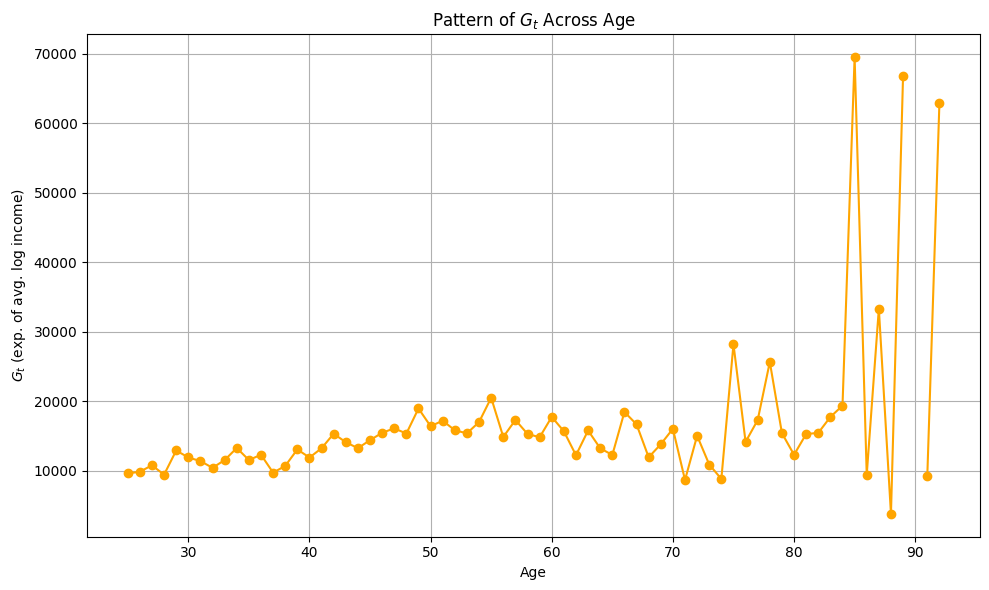

In [ ]:
# Plotting (with extreme ages included)
plt.figure(figsize=(10, 6))
plt.plot(process_df["age"], process_df["Gt"], color='orange', marker='o', linestyle='-')
plt.xlabel("Age")
plt.ylabel(r"$G_t$ (exp. of avg. log income)")
plt.title("Pattern of $G_t$ Across Age")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
process_df.to_csv('data3.csv',index=False, encoding = 'utf-8-sig')

In [ ]:
df.columns

Index(['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6bc3', 'm6bc6',
       'HH_wealth2_x', 'HH_wealth2_y', 'm6ac3', 'm6ac6', 'm6ac7',
       'HH_wealth1_x', 'HH_wealth1_y', 'm7c15', 'm7c32', 'm7c36', 'm7c39',
       'HH_exp6', 'm5b3c2_x', 'm5b3c2_y', 'HH_exp5', 'm5b2c2_x', 'm5b2c3_x',
       'm5b2c2_y', 'm5b2c3_y', 'HH_exp4', 'm5b1c4_x', 'm5b1c5_x', 'm5b1c4_y',
       'm5b1c5_y', 'HH_exp3', 'm5a2c6_x', 'm5a2c10_x', 'm5a2c6_y', 'm5a2c10_y',
       'HH_exp2', 'm5a1c2b_x', 'm5a1c3b_x', 'm5a1c2b_y', 'm5a1c3b_y',
       'HH_exp1', 'matv', 'hsize', 'm1ac2', 'm1ac3', 'age', 'm4ac6', 'm4ac7',
       'm4ac8', 'm4ac16', 'm4ac17', 'm4ac18', 'm4ac11', 'm4ac12f', 'm4ac21',
       'm4ac22f', 'm4ac25', 'indi_income', 'HH_Income', 'HH_wealth1',
       'HH_wealth2', 'HH_Wealth', 'log_income'],
      dtype='object')

In [ ]:
# Load muc4a
work_data = pd.read_csv('/content/muc4a.csv')


# Sort columns
selected_col = [
    'tinh', 'huyen', 'xa', 'diaban', 'hoso', 'matv',
    'm4ac6', 'm4ac7', 'm4ac8',       # primary job components
    'm4ac16', 'm4ac17', 'm4ac18',    # secondary job components
    'm4ac11', 'm4ac12f', 'm4ac21', 'm4ac22f', 'm4ac25'  # income components
]
work_data = work_data[selected_col]

# Calculate annual working hours for both jobs
work_data['primary_job_hours'] = work_data['m4ac6'] * work_data['m4ac7'] * work_data['m4ac8']
work_data['secondary_job_hours'] = work_data['m4ac16'] * work_data['m4ac17'] * work_data['m4ac18']
work_data['annual_working_hours'] = work_data[['primary_job_hours', 'secondary_job_hours']].sum(axis=1)

# Total income per person
work_data['individual_income'] = work_data[['m4ac11', 'm4ac12f', 'm4ac21', 'm4ac22f', 'm4ac25']].sum(axis=1)

# Filter rows
work_data.dropna(subset=['annual_working_hours', 'individual_income'], inplace=True)
work_data = work_data[~((work_data['annual_working_hours'] > 0) & (work_data['individual_income'] == 0))]
work_data['is_worker'] = work_data['annual_working_hours'] > 0

# Group to household level
hh_data = work_data.groupby(['tinh', 'huyen', 'xa', 'diaban', 'hoso']).agg(
    total_hours=('annual_working_hours', 'sum'),
    total_income=('individual_income', 'sum'),
    num_workers=('is_worker', 'sum')
).reset_index()

# Add household size
hh_size = df[['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'hsize']].drop_duplicates()
hh_size = hh_size.dropna(subset=['hsize'])
hh_data = hh_data.merge(hh_size, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')

# Calculate average hours per worker and normalize
hh_data = hh_data[hh_data['num_workers'] > 0]
hh_data['avg_hours_per_worker'] = hh_data['total_hours'] / hh_data['num_workers']
hh_data['normalized_hours'] = hh_data['avg_hours_per_worker'] / (260 * 16) #260 days x 16 hours of active
hh_data = hh_data[(hh_data['total_income'] > 0) & (hh_data['normalized_hours'] > 0)]

# View result
print(hh_data)

      tinh  huyen    xa  diaban  hoso  total_hours  total_income  num_workers  \
0      101      1   3.0       1    14       4320.0       56468.0            2   
1      101      1   3.0       1    15       2496.0       42351.0            1   
2      101      1   9.0      19    20       3952.0       47203.0            2   
3      101      1  15.0      50    13       5232.0      163382.0            2   
4      101      1  15.0      50    14       4224.0      152463.0            2   
...    ...    ...   ...     ...   ...          ...           ...          ...   
6241   823     11  19.0      29    14        672.0        3774.0            1   
6243   823     13   1.0       4    13       4560.0       17327.0            2   
6246   823     13  11.0       4    13       3180.0       60738.0            2   
6250   823     13  12.0      25    15       4060.0       27677.0            3   
6252   823     13  17.0       1    20       2496.0       31399.0            1   

      hsize  avg_hours_per_

<ipython-input-111-6bfddead87b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_data['primary_job_hours'] = work_data['m4ac6'] * work_data['m4ac7'] * work_data['m4ac8']
<ipython-input-111-6bfddead87b9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_data['secondary_job_hours'] = work_data['m4ac16'] * work_data['m4ac17'] * work_data['m4ac18']
<ipython-input-111-6bfddead87b9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [ ]:
df['total_consumption'] = df[['HH_exp1', 'HH_exp2', 'HH_exp3', 'HH_exp4', 'HH_exp5', 'HH_exp6']].sum(axis=1, skipna=True)

# Extract columns for merging
consumption = df[['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'total_consumption']].copy()

# Merge by household identifiers
hh_final = hh_data.merge(consumption, on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'], how='inner')

# Compute average consumption per household member
hh_final['avg_consumption'] = hh_final['total_consumption'] / hh_final['hsize']

# Filter (clean data)
hh_final = hh_final[(hh_final['avg_consumption'] > 0)]

hh_final

,tinh,huyen,xa,diaban,hoso,total_hours,total_income,num_workers,hsize,avg_hours_per_worker,normalized_hours,total_consumption,avg_consumption
0,101,1,3.0,1,14,4320.0,56468.0,2,3,2160.000000,0.519231,94038.0,31346.000000
1,101,1,3.0,1,15,2496.0,42351.0,1,2,2496.000000,0.600000,93917.6,46958.800000
2,101,1,9.0,19,20,3952.0,47203.0,2,3,1976.000000,0.475000,46195.6,15398.533333
3,101,1,15.0,50,13,5232.0,163382.0,2,4,2616.000000,0.628846,97436.8,24359.200000
4,101,1,15.0,50,14,4224.0,152463.0,2,3,2112.000000,0.507692,101492.8,33830.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225,823,11,19.0,29,14,672.0,3774.0,1,4,672.000000,0.161538,23075.3,5768.825000
4226,823,13,1.0,4,13,4560.0,17327.0,2,5,2280.000000,0.548077,14784.6,2956.920000
4227,823,13,11.0,4,13,3180.0,60738.0,2,3,1590.000000,0.382212,44707.0,14902.333333
4228,823,13,12.0,25,15,4060.0,27677.0,3,6,1353.333333,0.325321,15570.9,2595.150000


In [ ]:
X = sm.add_constant(hh_final['normalized_hours'])  # Add constant for intercept
Y = hh_final['avg_consumption']

# Fit OLS model
ols_model = sm.OLS(Y, X).fit()

# Print OLS summary table
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_consumption   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sun, 18 May 2025   Prob (F-statistic):           1.03e-25
Time:                        08:53:23   Log-Likelihood:                -42811.
No. Observations:                4230   AIC:                         8.563e+04
Df Residuals:                    4228   BIC:                         8.564e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4305.6827    304.074  

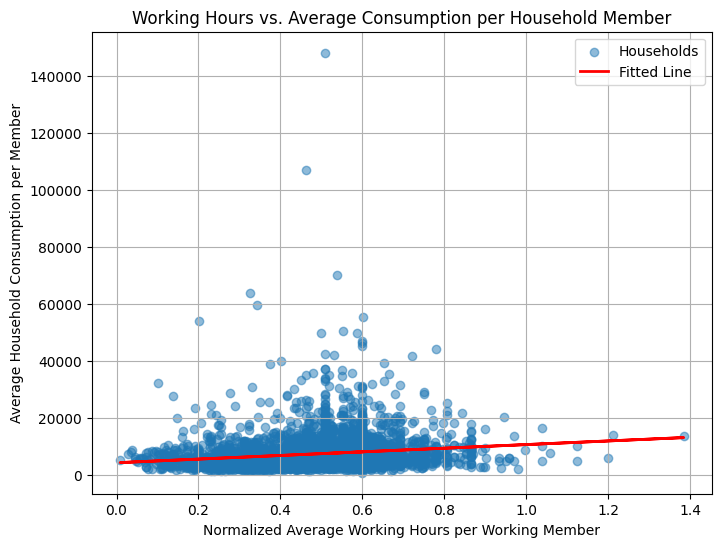

In [ ]:
#Scatter plot
# Define X and Y
x = hh_final['normalized_hours']
y = hh_final['avg_consumption']

# Fit a line: y = slope * x + intercept
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Plot scatter and fitted line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label='Households')
plt.plot(x, line, color='red', linewidth=2, label=f'Fitted Line')
plt.title('Working Hours vs. Average Consumption per Household Member')
plt.xlabel('Normalized Average Working Hours per Working Member')
plt.ylabel('Average Household Consumption per Member')
plt.legend()
plt.grid(True)
plt.show()

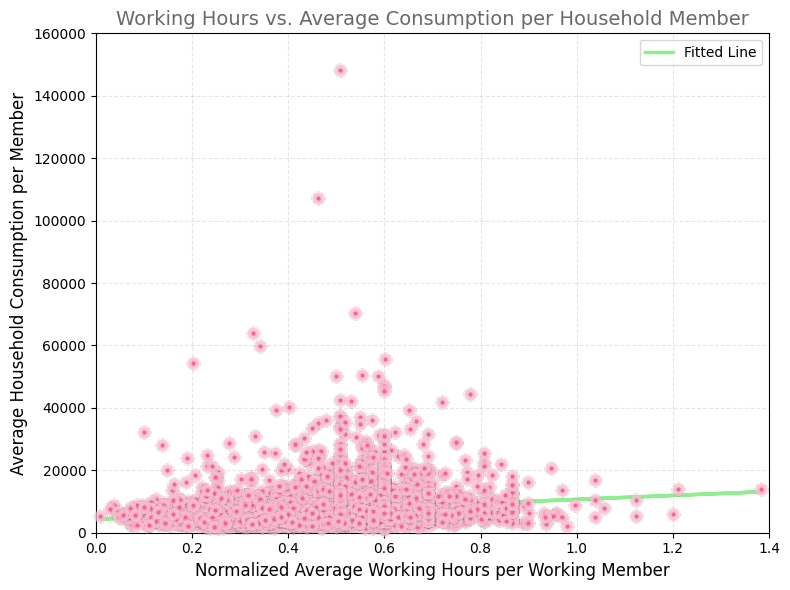

In [ ]:
# an other version which is more beautiful than the above (with each dot is pinky flower)
# note: download the pink_flower.png file to run this code

from PIL import Image
import matplotlib.offsetbox as offsetbox

# === Load your dataset ===
x = hh_final['normalized_hours']
y = hh_final['avg_consumption']


# === Linear fit ===
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# === Load the transparent flower icon ===
flower_path = r"/content/pink_flower.png"  # <- update if needed
flower_img = Image.open(flower_path).convert("RGBA").resize((12,12))

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the fitted line in hot pink
ax.plot(x, line, color='#90EE90', linewidth=2.5, label='Fitted Line')  # lime green


# Plot each flower icon instead of a scatter dot
for xi, yi in zip(x, y):
    imgbox = offsetbox.OffsetImage(flower_img, zoom=1)
    ab = offsetbox.AnnotationBbox(imgbox, (xi, yi), frameon=False)
    ax.add_artist(ab)

# === Axis Settings (same as your clean version) ===
ax.set_xlim(0, 1.4)
ax.set_ylim(0, 160000)

# === Labels and Styling ===
ax.set_title('Working Hours vs. Average Consumption per Household Member', fontsize=14, color='dimgray')
ax.set_xlabel('Normalized Average Working Hours per Working Member', fontsize=12)
ax.set_ylabel('Average Household Consumption per Member', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
df = df.merge(
    hh_final[['tinh', 'huyen', 'xa', 'diaban', 'hoso',
                'total_hours', 'total_income', 'num_workers',
                'avg_hours_per_worker', 'normalized_hours',
                'avg_consumption']],
    on=['tinh', 'huyen', 'xa', 'diaban', 'hoso'],
    how='left'
)

# Save to CSV
df.to_csv('finalized_data.csv', index=False)

In [ ]:
df.columns

Index(['tinh', 'huyen', 'xa', 'diaban', 'hoso', 'm6bc3', 'm6bc6',
       'HH_wealth2_x', 'HH_wealth2_y', 'm6ac3', 'm6ac6', 'm6ac7',
       'HH_wealth1_x', 'HH_wealth1_y', 'm7c15', 'm7c32', 'm7c36', 'm7c39',
       'HH_exp6', 'm5b3c2_x', 'm5b3c2_y', 'HH_exp5', 'm5b2c2_x', 'm5b2c3_x',
       'm5b2c2_y', 'm5b2c3_y', 'HH_exp4', 'm5b1c4_x', 'm5b1c5_x', 'm5b1c4_y',
       'm5b1c5_y', 'HH_exp3', 'm5a2c6_x', 'm5a2c10_x', 'm5a2c6_y', 'm5a2c10_y',
       'HH_exp2', 'm5a1c2b_x', 'm5a1c3b_x', 'm5a1c2b_y', 'm5a1c3b_y',
       'HH_exp1', 'matv', 'hsize', 'm1ac2', 'm1ac3', 'age', 'm4ac6', 'm4ac7',
       'm4ac8', 'm4ac16', 'm4ac17', 'm4ac18', 'm4ac11', 'm4ac12f', 'm4ac21',
       'm4ac22f', 'm4ac25', 'indi_income', 'HH_Income', 'HH_wealth1',
       'HH_wealth2', 'HH_Wealth', 'log_income', 'total_consumption',
       'total_hours', 'total_income', 'num_workers', 'avg_hours_per_worker',
       'normalized_hours', 'avg_consumption', 'log_hours'],
      dtype='object')

In [ ]:
df['log_hours'] = np.log(df['normalized_hours'])

# Step 3: Group by age and compute average log values
log_hours_age_group = df.groupby('age')['log_hours'].mean()
new_gt = np.exp(log_hours_age_group)

# Create a DataFrame
new_gt = pd.DataFrame({
    'Age': new_gt.index,
    'Gt': new_gt.values
})

# Export to CSV
new_gt.to_csv('updated_gt.csv', index=False)



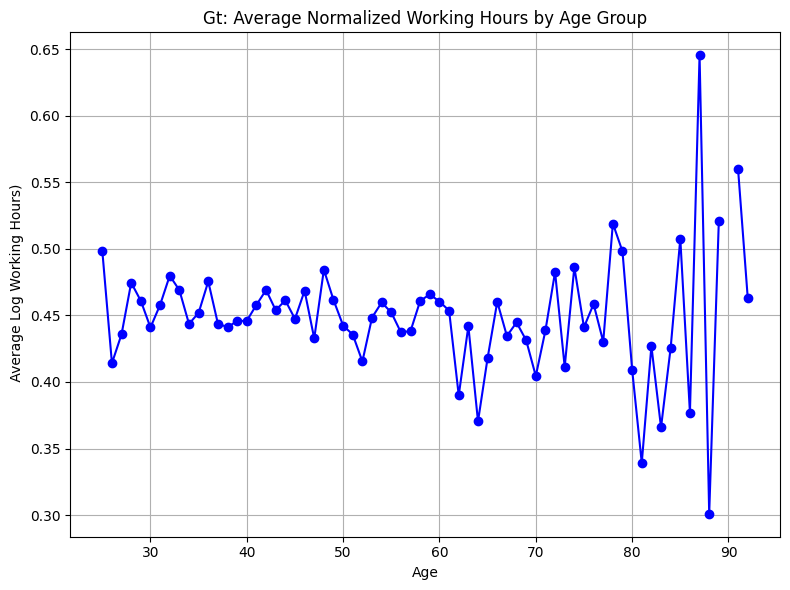

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(new_gt['Age'], new_gt['Gt'], marker='o', linestyle='-', color='b')
plt.title('Gt: Average Normalized Working Hours by Age Group')
plt.xlabel('Age')
plt.ylabel(' Average Log Working Hours)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("/content/finalized_data.csv")

# Drop rows with missing values
df = df.dropna(subset=["total_income", "total_consumption", "HH_Wealth", "age"])

# Create a new column for age groups (5-year bins)
age_bins = list(range(20, 85, 5))  # e.g., 20–24, 25–29, ..., 80–84
age_labels = [f"{i}-{i+4}" for i in age_bins[:-1]]
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

# Calculate ratios
df["consumption_to_income"] = df["total_consumption"] / df["total_income"]
df["wealth_to_income"] = df["HH_Wealth"] / df["total_income"]

# Group by age group and compute statistics
grouped_stats = df.groupby("age_group").agg({
    "consumption_to_income": "mean",
    "wealth_to_income": "mean",
    "total_consumption": "var"
}).rename(columns={
    "total_consumption": "consumption_variance"
})

# Show the results
print(grouped_stats)

# Optional: Save to CSV
# grouped_stats.to_csv("age_group_summary_statistics.csv")


           consumption_to_income  wealth_to_income  consumption_variance
age_group                                                               
20-24                        NaN               NaN                   NaN
25-29                   2.898996          3.382270          2.199277e+08
30-34                   3.161397          7.143595          3.291132e+08
35-39                   3.862334          7.226388          2.096600e+08
40-44                   3.829098          7.529010          3.057302e+08
45-49                   3.205159          8.504305          4.145537e+08
50-54                   3.810067          8.693933          9.561165e+08
55-59                   3.585104          6.276802          6.534557e+08
60-64                   3.418057          8.580961          9.980919e+08
65-69                   3.153631         10.544835          5.419577e+08
70-74                   3.084113          4.527235          3.821556e+08
75-79                   2.465252          3.184701 

<ipython-input-2-7d3925ae793c>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = df.groupby("age_group").agg({
